In [1]:
# MS571 - Aprendizado de Máquinas: Aspectos Teóricos e Práticos
# Projeto 1 - Redes Neurais e Seleção de Modelo

# Autores:
# Amanda Rocha Faga - RA: 212573
# Caique Oliveira Alves da Silva - RA: 168023
# Vítor Hugo Miranda Mourão - RA: 137856 (Obs: Realizou o trancamento da disciplina ao final do projeto)

In [2]:
# Importação das bibliotecas utilizadas:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize 
import copy as cp

In [3]:
# Importação dos exemplos rotulados:
X = pd.read_csv("imageMNIST.csv", header=None).values
y = pd.read_csv("labelMNIST.csv", header=None).values

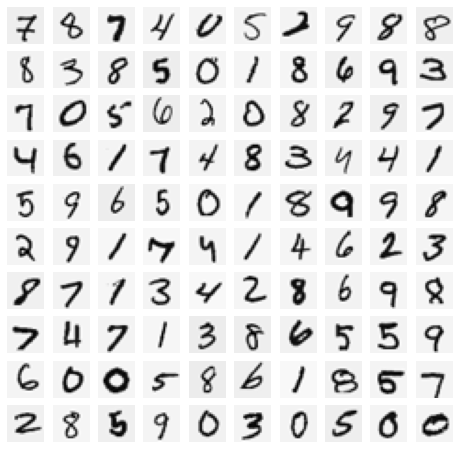

In [4]:
# Visualização de alguns exemplos:
fig,axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        axis[i,j].imshow(X[np.random.randint(0,5001),:].reshape(20,20,order="F"),cmap="binary")
        axis[i,j].axis("off")

In [5]:
# Definição das funções utilizadas na primeira etapa da Parte I do projeto:

In [6]:
# Função de ativação (sigmoide/logística):
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [7]:
# Derivada da função de ativação:
def sigmoid_gradient(z):
    return sigmoid(z)*(1-sigmoid(z))

In [8]:
# Forward Propagation:
def activation_forward(X, hidden_layers, theta):
    activation = [0 for i in range(len(hidden_layers)+2)] 
    activation[0] = X
    for l in range(1,len(hidden_layers)+2):
        activation[l] = sigmoid(activation[l-1] @ theta[l-1].T)
        if l != (len(hidden_layers)+1):
            n = activation[l].shape[0]
            activation[l] = np.hstack((np.ones([n,1]), activation[l])) # Inserção do bias
    return activation

In [9]:
# Função de custo:
def compute_cost(X,y,theta,input_layer_size, hidden_layers, hidden_layer_size, num_labels, Lambda):
    
    m = X.shape[0] # Número de exemplos rotulados
    X = np.hstack((np.ones([m,1]), X)) # Inserção do bias na primeira coluna da matriz de design
    J = 0 # Inicialização da função de custo
    y10 = np.zeros((m,num_labels)) # Inicialização da camada de saída
    activation = activation_forward(X, hidden_layers, theta)
        
    # Definição da camada de saída:
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = (np.where(y==i,1,0).reshape(m,1))
        
    # Cálculo da função de custo:
    for j in range(num_labels):
        J = J + sum(-y10[:,j]*np.log(activation[-1][:,j] + 0.001)-
                    (1-y10[:,j])*np.log(1-activation[-1][:,j] + 0.001))
    cost = (1/m)*J
    
    # Função de custo regularizada:
    sqr_theta_sum = 0
    for i in range(len(hidden_layers)+1):
        sqr_theta_sum += np.sum(theta[i][:,1:]**2)
    reg_J = cost + Lambda/(2*m)*sqr_theta_sum
    
    # Backpropagation:
    activation = activation[1:]
    grads = []
    d_final = activation[-1]-y10
    grad = d_final.T @ activation[-2]
    grads.append(grad)
    delta = d_final.T
    for i in range(len(theta)-2,0,-1):
        delta = np.multiply((theta[i+1].T @ delta), (sigmoid_gradient(activation[i])).T)
        delta = np.delete(delta,0,0)
        grad = delta @ activation[i-1]
        grads.append(grad)
    delta = np.multiply((theta[1].T @ delta), (sigmoid_gradient(np.hstack((np.ones((m,1)), X @ theta[0].T)))).T)
    delta = np.delete(delta,0,0)
    grad = delta @ X
    grads.append(grad)
    
    # Gradiente regularizado:
    grads=list(reversed(grads))
    for i in range(0,len(grads)):
        grads[i] = 1/m*grads[i]
        grads[i] = grads[i]+(Lambda/m)*np.hstack((np.zeros([theta[i].shape[0],1]),theta[i][:,1:]))
     
    return cost, grads, reg_J

In [10]:
# Inicialização aleatória dos pesos - parte 1:
def rand_init_weights(L_in, L_out):
    epi = (6**1/2)/((L_in+L_out)**(1/2))
    W = np.random.rand(L_out,L_in+1)*(2*epi)-epi
    return W

In [11]:
# Inicialização aleatória dos pesos - parte 2:
def theta_init(X, y, hidden_layers):
    THETA = []
    THETA.append(rand_init_weights(X.shape[1], hidden_layers[0]))
    for i in range(1,len(hidden_layers)):
        THETA.append(rand_init_weights(hidden_layers[i-1],hidden_layers[i]))
    THETA.append(rand_init_weights(hidden_layers[-1],y.shape[1]))
    return THETA

In [12]:
# Algoritmo do gradiente descendente:
def gradient_descent(X,y,theta,alpha,nbr_iter,Lambda,input_layer_size, hidden_layers,
                    hidden_layer_size,num_labels):
    
    J_history = []
    
    for i in range(nbr_iter):
        cost, grad, reg_J = compute_cost(X,y,theta,input_layer_size,hidden_layers,
                                 hidden_layer_size,num_labels,Lambda)
        for l in range(len(hidden_layers)+1):
            theta[l] -= alpha*grad[l]
        J_history.append(cost)
        
    return theta, J_history

In [13]:
# Previsão:
def prediction(X,THETA, hidden_layers):
    m = X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    activation = activation_forward(X, hidden_layers, THETA) # Cálculo da ativação no forward propagation
    return np.argmax(activation[-1], axis = 1)+1

In [14]:
# Parte I - Redes Neurais:

In [15]:
# Arquitetura da rede neural:
input_layer_size = 400 # 400 neurônios na camada de entrada, 1 para cada pixel da imagem 20x20
hidden_layers = [25] # 1 camada escondida com 25 neurônios
hidden_layer_size = 25 # tamanho da camada escondida
num_labels = 10 # 10 neurônios na camada de saída, um para cada dígito entre 0 e 9

In [16]:
# Definição dos hiperparâmetros:
nbr_iter = 400 # Número de iterações
alpha = 0.8 # Taxa de aprendizado
Lambda = 1 # Termo regularizador

In [17]:
# Treinamento da rede neural:
m = X.shape[0]
y10 = np.zeros((m,num_labels))
initial_theta = theta_init(X,y10,hidden_layers)
theta,J_history = gradient_descent(X,y,initial_theta,alpha,nbr_iter,Lambda,input_layer_size,hidden_layers,hidden_layer_size,num_labels)

In [18]:
# Previsão da rede neural treinada e porcentagem de acertos:
pred = prediction(X,theta, hidden_layers)
print("Porcentagem de imagens classificadas corretamente: ", format(sum(pred[:,np.newaxis]==y)[0]/5000*100, '.2f'), "%")

Porcentagem de imagens classificadas corretamente:  92.70 %



Tabela com as previsões incorretas: 
 [[ 8.  3.  8. 10. 10.  5.  1.  2.  7.  5.]
 [ 4.  5.  3.  4.  8.  5.  8. 10.  8.  5.]
 [ 7.  2.  1.  1.  7.  6.  3.  6.  4.  9.]
 [ 3.  7.  2.  5.  2.  1.  7.  2. 10.  7.]
 [ 3.  1.  2.  4.  7.  4.  2.  7.  7.  6.]
 [ 4.  4.  3. 10.  7.  1.  4.  1.  9.  1.]
 [ 8.  1.  8.  7.  9.  5.  7.  9.  6.  1.]
 [ 4.  9.  3. 10.  9.  6.  2. 10.  3.  8.]
 [ 3.  4.  1.  3.  3.  7.  4.  3.  9.  8.]
 [ 5.  7.  4.  3.  8.  7.  2. 10.  3.  7.]]


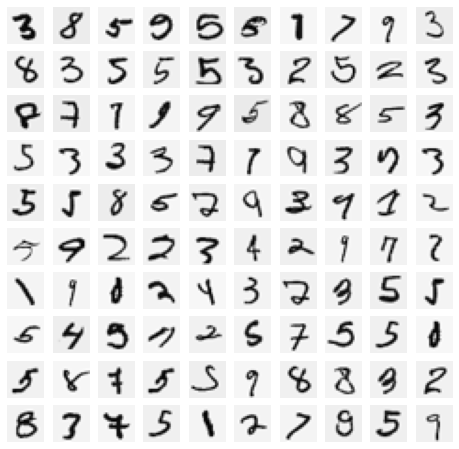

In [19]:
# Exibição dos exemplos rotulados incorretamente:
wrong = np.zeros((1,3))
for i in range(len(y)):
    if (y[i] != pred[i]):
        wrong = np.vstack((wrong, np.array([i, int(y[i]), pred[i]], dtype=object)))
wrong = np.delete(wrong, 0,0)

wrong_pred = np.zeros((10,10))
fig,axis = plt.subplots(10,10,figsize=(8,8))
for i in range(10):
    for j in range(10):
        aux = np.random.randint(0,len(wrong))
        row = wrong[aux][0]
        wrong_pred[i][j] = wrong[aux][2]
        axis[i,j].imshow(X[row,:].reshape(20,20,order="F"),cmap="binary")
        axis[i,j].axis("off")
        
print("\nTabela com as previsões incorretas: \n", wrong_pred)

In [20]:
# Definição das funções utilizadas na segunda etapa da Parte I do projeto:

In [21]:
# Função de checagem do gradiente:
def gradient_check(X,y, i, theta, input_layer_size, hidden_layers,hidden_layer_size, num_labels, Lambda, e = 10**(-4)):
    
    # Inserção do bias na camada de entrada:
    m = X.shape[0] # 
    theta[i] += e
    
    # Inicialização do custo e da camada de saída:
    J1 = 0
    J2 = 0
    y10 = np.zeros((m,num_labels))
    
    # Cálculo da ativação com os novos pesos:
    activation = activation_forward(X, hidden_layers, theta)
        
    # Definição da camada de saída:
    for n in range(1,num_labels+1):
        y10[:,n-1][:,np.newaxis] = np.where(y==n,1,0)
        
    # Cálculo da função de custo
    for j in range(num_labels):
        J1 = J1 + sum(-y10[:,j]*np.log(activation[-1][:,j] + 0.001)-
                    (1-y10[:,j])*np.log(1-activation[-1][:,j] + 0.001))
    cost = 1/m*J1

    theta[i] = theta[i] - 2*e
    
    # Cálculo da ativação com os novos pesos:
    activation = activation_forward(X, hidden_layers, theta)
        
    # Definição da camada de saída:
    for n in range(1,num_labels+1):
        y10[:,n-1][:,np.newaxis] = np.where(y==n,1,0)
        
    # Cálculo da função de custo:
    for j in range(num_labels):
        J2 = J2 + sum(-y10[:,j]*np.log(activation[-1][:,j] + 0.001)-
                    (1-y10[:,j])*np.log(1-activation[-1][:,j] + 0.001))
    cost = (1 / m) * J2

    # Cálculo da aproximação:
    aprox = (J1 - J2)/2*e

    return aprox

In [22]:
# Custo com checagem do gradiente:
def compute_cost_check(X,y,theta,input_layer_size, hidden_layers,hidden_layer_size, num_labels, Lambda):
    
    m = X.shape[0] # Número de exemplos rotulados
    X = np.hstack((np.ones([m,1]), X)) # Inserção do bias na camada de entrada
    J = 0 # Inicialização da função de custo
    y10 = np.zeros((m,num_labels)) # Inicialização da camada de saída
    
    # Cálculo da ativação no forward propagation:
    activation = activation_forward(X, hidden_layers, theta)
        
    # Definição da camada de saída:
    for i in range(1,num_labels+1):
        y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
        
    # Cálculo da função de custo:
    for j in range(num_labels):
        J = J + sum(-y10[:,j]*np.log(activation[-1][:,j] + 0.001)-(1-y10[:,j])*np.log(1-activation[-1][:,j] + 0.001))
    cost = 1/m*J
    
    # Função de custo regularizada:
    sqr_theta_sum = 0
    for i in range(len(hidden_layers)+1):
        sqr_theta_sum += np.sum(theta[i][:,1:]**2)
    reg_J = cost + Lambda/(2*m)*sqr_theta_sum
    
    # Backpropagation:
    activation = activation[1:]
    grads = []
    grads_check = []
    d_final = activation[-1]-y10
    grad = d_final.T @ activation[-2]
    grads.append(grad)
    delta = d_final.T
    for i in range(len(theta)-2,0,-1):
        delta = np.multiply((theta[i+1].T @ delta), (sigmoid_gradient(activation[i])).T)
        delta = np.delete(delta,0,0)
        grad = delta @ activation[i-1]
        grads.append(grad)

    # Checagem:
    for i in range(len(theta)):
      aprox = gradient_check(X,y, i, theta,input_layer_size, hidden_layers,
                hidden_layer_size, num_labels, Lambda)
      grads_check.append(aprox)

    delta = np.multiply((theta[1].T @ delta), (sigmoid_gradient(np.hstack((np.ones((m,1)), X @ theta[0].T)))).T)
    delta = np.delete(delta,0,0)
    grad = delta @ X
    grads.append(grad)
    
    # Gradiente regularizado:
    grads=list(reversed(grads))
    for i in range(0,len(grads)):
        grads[i] = 1/m*grads[i]
        grads[i] = grads[i]+(Lambda/m)*np.hstack((np.zeros([theta[i].shape[0],1]),theta[i][:,1:]))

    # Checagem do gradiente regularizado:
    for i in range(0,len(grads_check)):
        grads_check[i] = 1/m*grads_check[i]
        grads_check[i] = grads_check[i]+(Lambda/m)*np.hstack((np.zeros([theta[i].shape[0],1]),theta[i][:,1:]))
     
    return cost, grads, grads_check, reg_J

In [23]:
# Função de vetorização dos pesos:
def vectorize(theta):
    dim=[]
    for h in theta:
        dim.append(h.shape[0]*h.shape[1])
    vector=theta[0].flatten()
    for r in theta[1:]:
        vector=np.hstack([vector,r.flatten()])
    return vector, dim

In [24]:
# Função da matriz:
def Matrix(vector,b,a,m,n,dim,nbr_classes):
    matrix=[]
    matrix.append(vector[:dim[0]].reshape(a[0],n+1))
    aux=cp.deepcopy(dim)
    for i in range(1,b-2):
        aux=cp.deepcopy(dim)
        matrix.append(vector[aux[i-1]:(aux[i-1]+aux[i])].reshape(a[i],a[i-1]+1))
        aux[i]=aux[i-1]+aux[i]
    g=np.sum(dim[:-1])
    matrix.append(vector[g:].reshape(nbr_classes,a[-1]+1))
    return matrix
vector, dim = vectorize(theta)

In [25]:
# Função de custo adaptada:
def minimize_cost(theta,X,y,input_layer_size, hidden_layers,hidden_layer_size, num_labels, Lambda):
    theta = Matrix(theta,len(hidden_layers)+2,hidden_layers,X.shape[0],X.shape[1],dim,num_labels)
    return compute_cost(X,y,theta,input_layer_size, hidden_layers, hidden_layer_size, num_labels, Lambda)[2]

In [26]:
# Aplicação do gradiente conjugado em um pequeno número de exemplos:
rand_rows = [np.random.randint(0,5000) for i in range(50)]
X_less = X[rand_rows,:]
y_less = y[rand_rows,:]

option = int(input("Você quer executar a função Minimize?\n*Se Sim, o tempo de execução será muito longo (~50 minutes)*\n0-Não 1-Sim: "))
if (option == 1):
    results = minimize(minimize_cost, vector, args = (X_less,y_less,input_layer_size,hidden_layers,hidden_layer_size,num_labels,Lambda), method='CG',jac=None, tol=None, callback=None, options={'maxiter':nbr_iter,'disp':True, 'gtol':1e-4})

Você quer executar a função Minimize?
*Se Sim, o tempo de execução será muito longo (~50 minutes)*
0-Não 1-Sim: 0


In [ ]:
# Checagem do gradiente:
compute_cost_check(X,y,theta,input_layer_size, hidden_layers, hidden_layer_size, num_labels, Lambda)

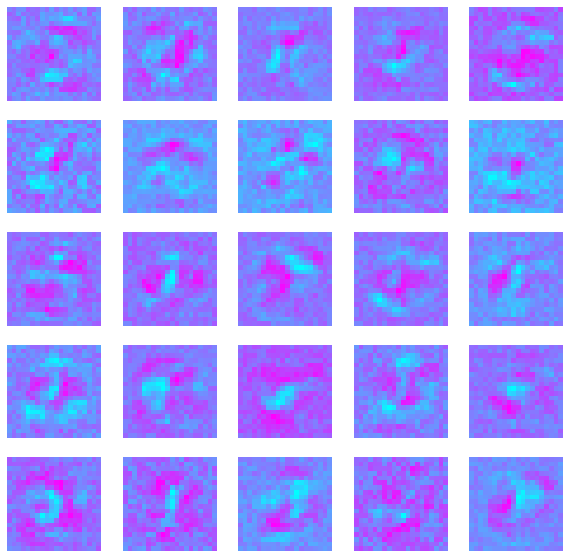

In [27]:
# Representação visual da forma que cada unidade de ativação atua na rede:
theta_nobias = np.delete(theta[0],0,1)
fig,axis = plt.subplots(5,5,figsize=(10,10))
k = 0
for i in range(5):
    for j in range(5):
        axis[i,j].imshow(theta_nobias[k].reshape(20,20,order="F"),cmap="cool")
        axis[i,j].axis("off")
        k += 1

In [28]:
# Parte 2 - Seleção de Modelo:

In [29]:
# Função utilizada para calcular a acurácia total das previsões:
def accuracy(prediction, y):
    aux = 0
    for i in range(len(prediction)):
        if (prediction[i] == y[i]):
            aux += 1
    return (aux/y.shape[0])*100

In [30]:
# Embaralhamento dos exemplos rotulados e divisão em conjuntos de treinamento, validação e teste:
df_X = X
df_y = pd.DataFrame(y)
df_X = pd.DataFrame(df_X)

# Concatenação do X (exemplos) e do y (rótulos) para embaralhá-los em conjunto:
df_Xy = pd.concat([df_X,df_y], axis = 1, ignore_index=True)

# Divisão dos dados: 
# 60% para treinamento, 20% para validação e 20% para teste
# Logo: 80% para treinamento + validação
train, validate, test = np.split(df_Xy.sample(frac = 1, random_state=777),[int(0.6*len(df_Xy)), int(0.8*len(df_Xy))])
train, validate, test = np.array(train), np.array(validate), np.array(test)

# Separação do X e do y para treino, validação e teste:
train_y = train[:,-1]
train_X = np.delete(train,-1,1)
validate_y = validate[:,-1]
validate_X = np.delete(validate,-1,1)
test_y = test[:,-1]
test_X = np.delete(test,-1,1)

# Definição dos hiperparâmetros:
m = train_X.shape[0]
y10_train = np.zeros((m,num_labels))
initial_theta_train = theta_init(train_X,y10_train,hidden_layers)
Lambda_train = [0,0.001,0.003,0.01,0.03,0.1,0.3,1,3,10]
accuracy_train = []
accuracy_validate = []
accuracy_test = []

A maior acurácia no conjunto de validação é 93.60 % com Lambda =  3
A acurácia no conjunto de treinamento + validação é 95.88 %
A acurácia no conjunto de teste é 92.20 %


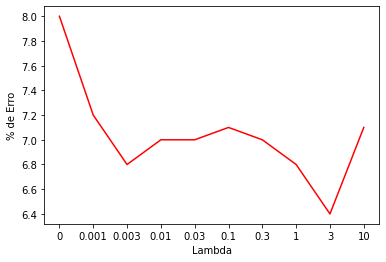

In [31]:
# Ajuste dos hiperparâmetros:
for Lambda in Lambda_train:
    # Chamada da função do gradiente descendente para treinar os parâmetros:
    theta_train, J_history_train = gradient_descent(train_X,train_y,initial_theta_train, alpha,nbr_iter,Lambda,input_layer_size,hidden_layers,hidden_layer_size,num_labels)
    # Avaliação do conjunto de validação:
    pred_validate = prediction(validate_X,theta_train, hidden_layers)
    accuracy_validate.append((accuracy(pred_validate,validate_y)))
    
# Encontrando o Lamba com maior acurácia:
Final_Lambda = Lambda_train[accuracy_validate.index(max(accuracy_validate))]
print("A maior acurácia no conjunto de validação é", format(max(accuracy_validate), '.2f'),"% com Lambda = ",Final_Lambda)

# Execução do conjunto de teste com o melhor Lambda:
train_validate_X = np.vstack((train_X, validate_X))
train_validate_y = np.hstack((train_y, validate_y))

# Chamada da função do gradiente descendente para treinar os parâmetros:
theta_test, J_history_validate = gradient_descent(train_validate_X,train_validate_y,initial_theta_train,alpha,nbr_iter,Final_Lambda,input_layer_size,hidden_layers,hidden_layer_size,num_labels)

# Encontrando a acurácia no conjunto de treinamento + validação:
pred_train = prediction(train_validate_X,theta_test, hidden_layers)
accuracy_train.append((accuracy(pred_train,train_validate_y)))
print("A acurácia no conjunto de treinamento + validação é", format(max(accuracy_train), '.2f'),"%")

# Avaliação do conjunto de teste:
pred_test = prediction(test_X,theta_test, hidden_layers)
accuracy_test.append((accuracy(pred_test, test_y)))
print("A acurácia no conjunto de teste é", format(max(accuracy_test), '.2f'),"%")

# Exibição do erro de validação:
error = [100-accuracy_validate[i] for i in range(len(accuracy_validate))]
fig,axis = plt.subplots()
ticks = range(len(Lambda_train))
plt.plot(ticks, error, color ="red")
plt.xlabel("Lambda")
plt.ylabel("% de Erro")
plt.xticks(ticks, Lambda_train)
plt.show()

# Chamada da função do gradiente descendente para exibir as curvas de aprendizado:
theta_train, J_history_train = gradient_descent(train_X,train_y,initial_theta_train,alpha,nbr_iter,Final_Lambda,input_layer_size,hidden_layers,hidden_layer_size,num_labels)

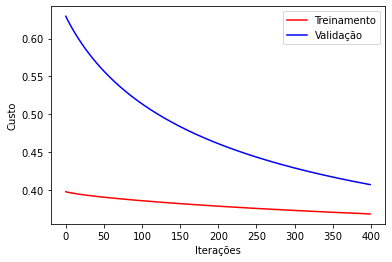

In [32]:
# Curvas de treinamento e de validação:
ticks = range(len(J_history_train))
plt.figure()
plt.plot(ticks, J_history_train, color = "red", label = "Treinamento")
plt.plot(ticks, J_history_validate, color = "blue", label = "Validação")
plt.xlabel("Iterações")
plt.ylabel("Custo")
plt.legend(loc="upper right")
plt.show()